In [1]:
import numpy as np
from scipy.io import loadmat

import os

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Blues'

import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    return onehot.cumsum(axis=time_axis)


policies = [
    'classical ens',
    # 'round robin greedy',
    'greedy',
    'ens jensen greedy'
]
names = [
    'ENS',
    # 'RR-Greedy',
    'One-step',
    'D-ENS'
]
assert len(policies) == len(names)

n_exps = 20
n_classes = 6
class_names = ['center', 'corner1', 'corner2', 'corner3', 'corner4']
init_size = 1
budget = 100

group_size = n_classes - 1

basepath = os.path.join('../../data/results/square', str(group_size))


queried_xs = np.ones((len(policies), n_exps, init_size + budget, 2)) * -1
class_counts = -1 * np.ones(
    (len(policies), n_exps, init_size + budget, n_classes), dtype=int
)

for p_ind, policy in enumerate(policies):
    for i in range(n_exps):
        queries = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__ind__{i + 1}.csv'),
            dtype=int
        ).flatten() - 1
        
        xs = loadmat(
            f'../../data/square/square_nearest_neighbors_{i + 1}.mat'
        )['x']
        
        queried_xs[p_ind, i, :, :] = xs[queries, :]
        
        labels = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1
        
        class_counts[p_ind, i, :] = labels_to_counts(labels)
        
assert np.all(queried_xs != -1)
assert np.all(class_counts != -1)

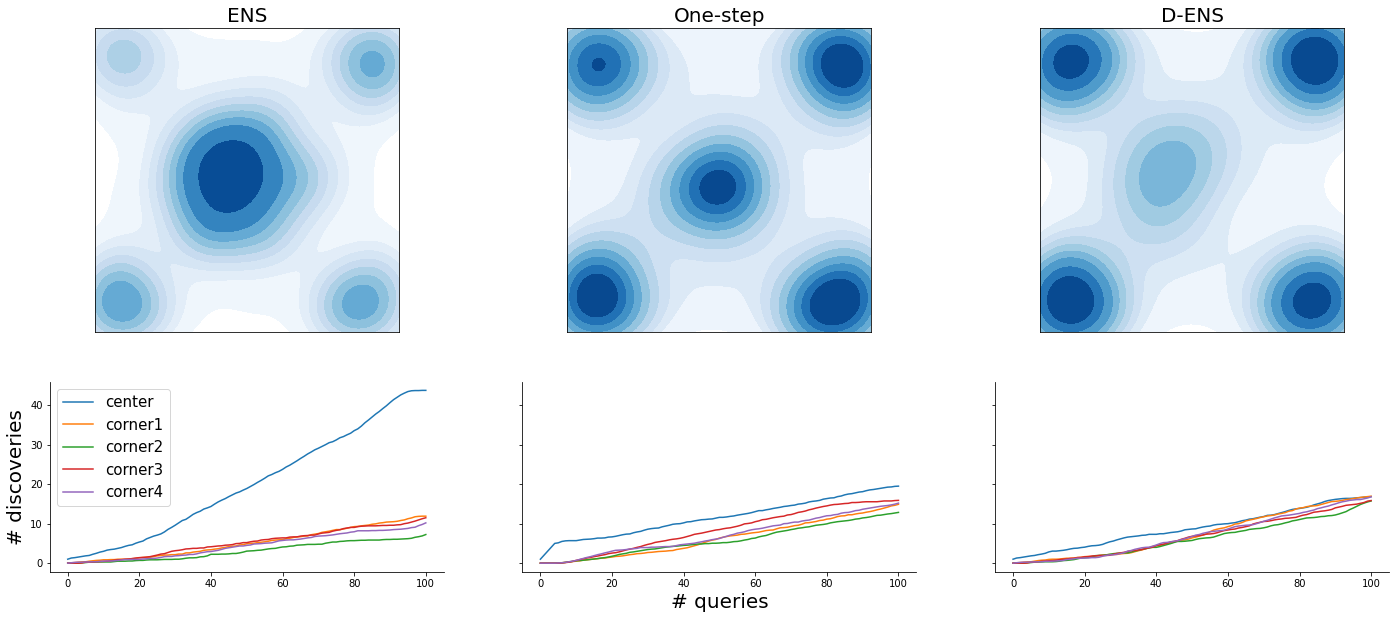

In [5]:
fontsize = 20

fig, ax = plt.subplots( 
    2,
    len(policies),
    figsize=(8 * len(policies), 10),
    gridspec_kw={'height_ratios': [1.6, 1]},
    sharey="row"
)

for i, (policy, name) in enumerate(zip(policies, names)):
    sns.kdeplot(
        x=queried_xs[i, :, :, 0].flatten(),
        y=queried_xs[i, :, :, 1].flatten(),
        ax=ax[0, i],
        fill=True,
        cmap="Blues"
    )
    
    ax[0, i].set_xlim(0, 1)
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xticklabels([])
    ax[0, i].set_xticks([])
    ax[0, i].set_yticklabels([])
    ax[0, i].set_yticks([])
    ax[0, i].set_aspect('equal', 'box')
    
    for c in range(1, n_classes):
        ax[1, i].plot(
            class_counts[i, :, :, c].mean(axis=0),
            c=f"C{c - 1}",
            label=class_names[c - 1]
        )
    
    ax[0, i].set_title(name, fontsize=fontsize)
    # ax[1, i].set_xlabel("# queries", fontsize=fontsize)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)

ax[1, len(policies) // 2].set_xlabel("# queries", fontsize=fontsize)
ax[1, 0].set_ylabel("# discoveries", fontsize=fontsize)
ax[1, 0].legend(loc="upper left", fontsize=15)

plt.show()